## Healthcare SalesWizard Lead Scoring and Prioritization

The purpose of this notebook is to build machine learning models to help company leadership make better sales decisions in the context of lead prioritization.  The two models that will be created are multi-variate logistic regression and random forest.

### Load and Preprocess Dataset

In [607]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
!pip install imbalanced-learn
!pip install brokenaxes

In [608]:
df = pd.read_csv("leadscore_dataset.csv")

In [609]:
df.head()

,business_unit,lead_contact,title,job_level,industry,team,channel,lead_product,sales_qualified
0,business_unit_1,Contact,Billing Coordinator,Staff-Level,Assisted Living Facility,team_1,Webinar,product_7,0
1,business_unit_1,Contact,Billing Specialist,Staff-Level,Home Health,team_1,Webinar,product_27,0
2,business_unit_1,Lead,Executive Director,NaN,Assisted Living Facility,team_1,MDR Meeting,product_40,0
3,business_unit_1,Contact,Billing,NaN,Ambulatory Health Care Facilities,team_2,Inbound Call,product_1,0
4,business_unit_1,Lead,Billing Director,Director-Level,Physician,team_3,Webinar,product_27,0


#### Understanding the Variables
* business_unit: Often, organizations will split product offerings into "Business Units". Business Units are supported by different Sales Teams.
* lead_contact: Indicates whether the person is known to the database (Contact) or is net new (Lead).
* title: Job title of the lead.
* job_level: Job level of the lead.
* industry: Industry of the person identified as a lead.
* team: Sales team which will be working with the lead (Often determined by industry and product combinations).
* channel: Activity channel the person took to become a lead.
* lead_product: Product of interest of the lead.
* sales_qualified: Target variable. This is the metric used to determine a success (1) or a failure (0).

In [610]:
# Check the number of 'titles' for leads
num_unique_titles = df['title'].nunique()
print(num_unique_titles)

3796


For the sake of our data science objectives, we will drop this column

In [611]:
df = df.drop('title', axis=1)

In [612]:
# Number of rows and columns
df.shape

(10000, 8)

In [613]:
# Check for missing values
df.isnull().sum()

business_unit         0
lead_contact          0
job_level          4967
industry             58
team                  0
channel               0
lead_product          3
sales_qualified       0
dtype: int64

In [614]:
# Impute 'Unknown' for missing values
df.fillna('Unknown', inplace=True)

In [615]:
# Check data types
df.dtypes

business_unit      object
lead_contact       object
job_level          object
industry           object
team               object
channel            object
lead_product       object
sales_qualified     int64
dtype: object

### Exploratory Data Analysis

#### Univariate Analysis

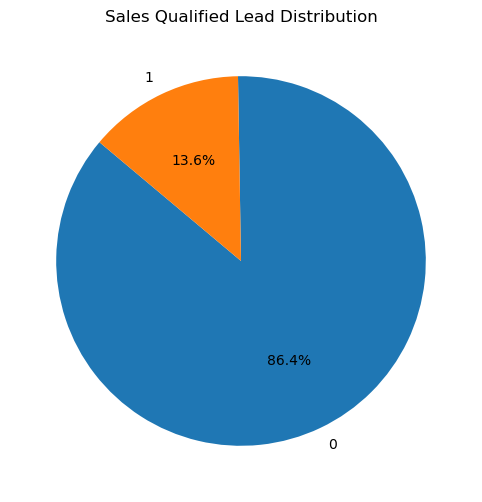

In [616]:
sales_qualified_counts = df['sales_qualified'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(sales_qualified_counts, labels=sales_qualified_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sales Qualified Lead Distribution')
plt.show()

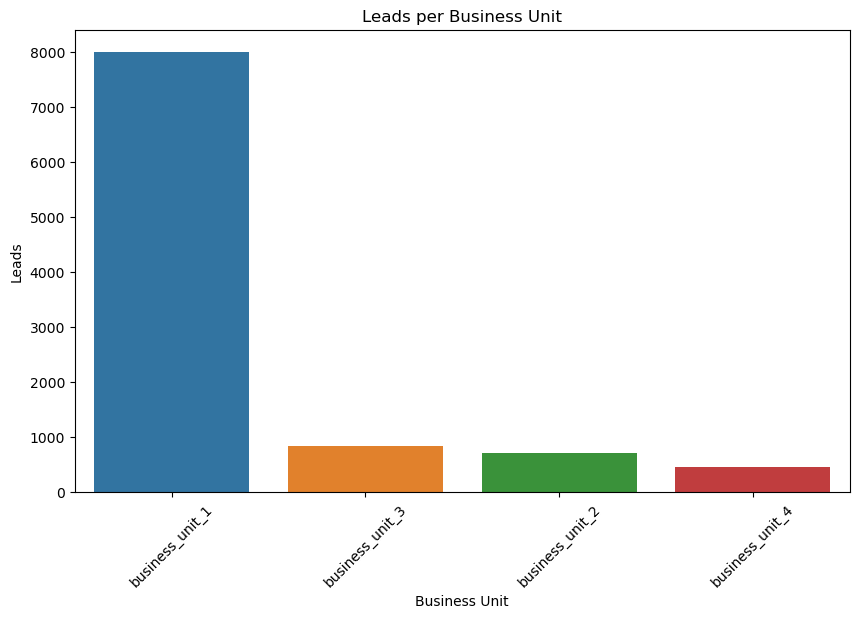

In [617]:
business_unit_counts = df['business_unit'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=business_unit_counts.index, y=business_unit_counts.values)
plt.title('Leads per Business Unit')
plt.xlabel('Business Unit')
plt.ylabel('Leads')
plt.xticks(rotation=45)  
plt.show()

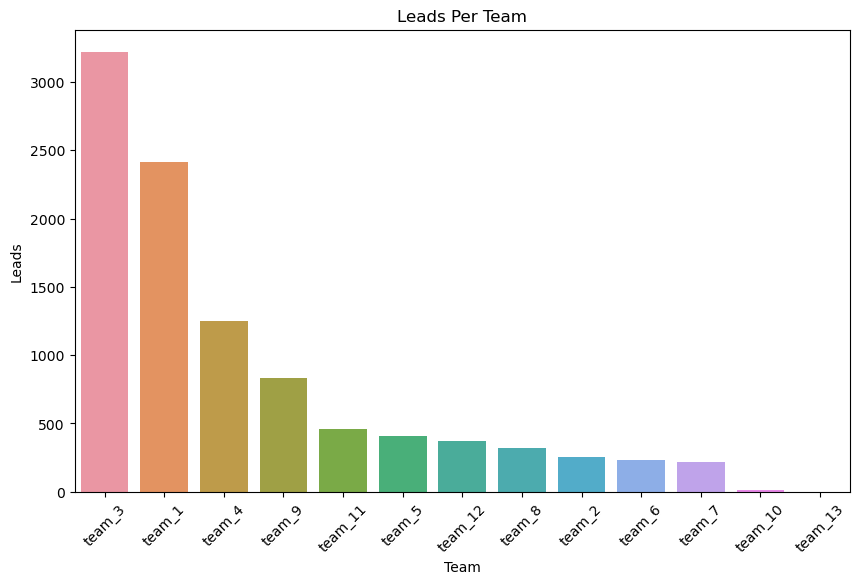

In [618]:
team_counts = df['team'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=team_counts.index, y=team_counts.values)
plt.title('Leads Per Team')
plt.xlabel('Team')
plt.ylabel('Leads')
plt.xticks(rotation=45) 
plt.show()

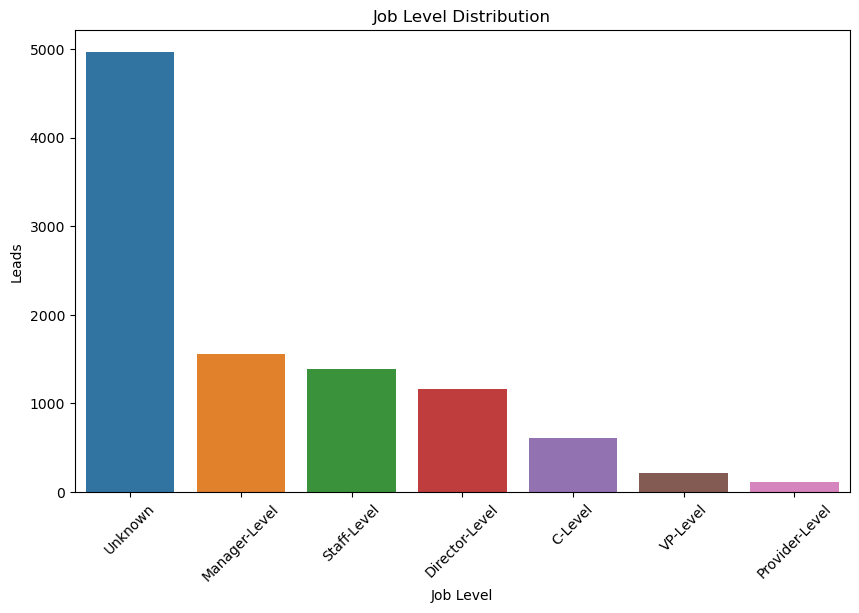

In [619]:
job_level_counts = df['job_level'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=job_level_counts.index, y=job_level_counts.values)
plt.title('Job Level Distribution')
plt.xlabel('Job Level')
plt.ylabel('Leads')
plt.xticks(rotation=45) 
plt.show()

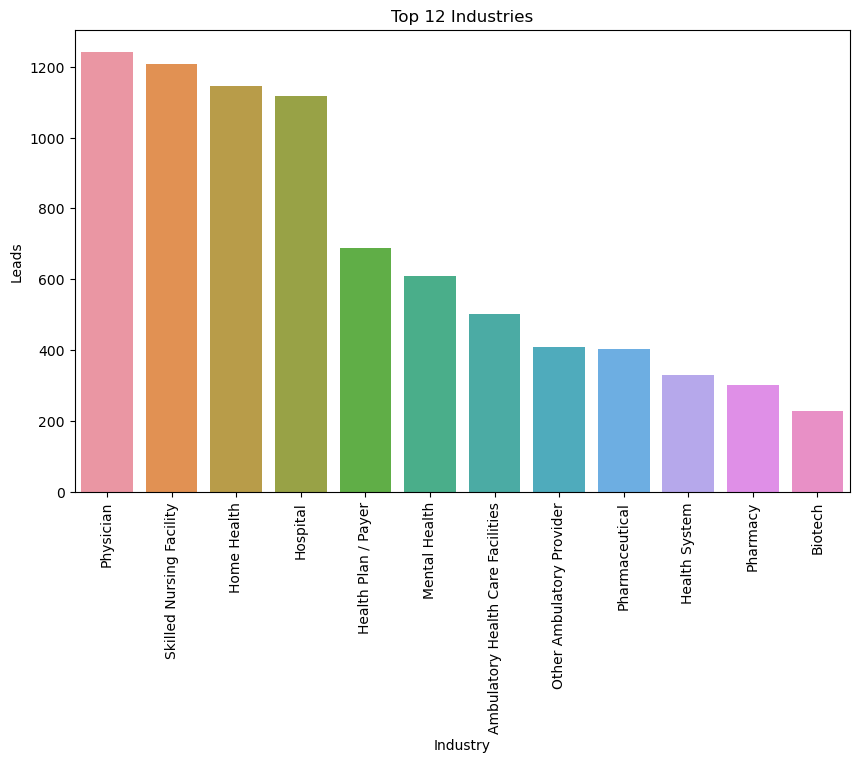

In [620]:
top_12_industries = df.industry.value_counts().head(12)
plt.figure(figsize=(10,6))
sns.barplot(x=top_12_industries.index, y=top_12_industries.values)
plt.title('Top 12 Industries')
plt.xlabel('Industry')
plt.ylabel('Leads')
plt.xticks(rotation=90)
plt.show()

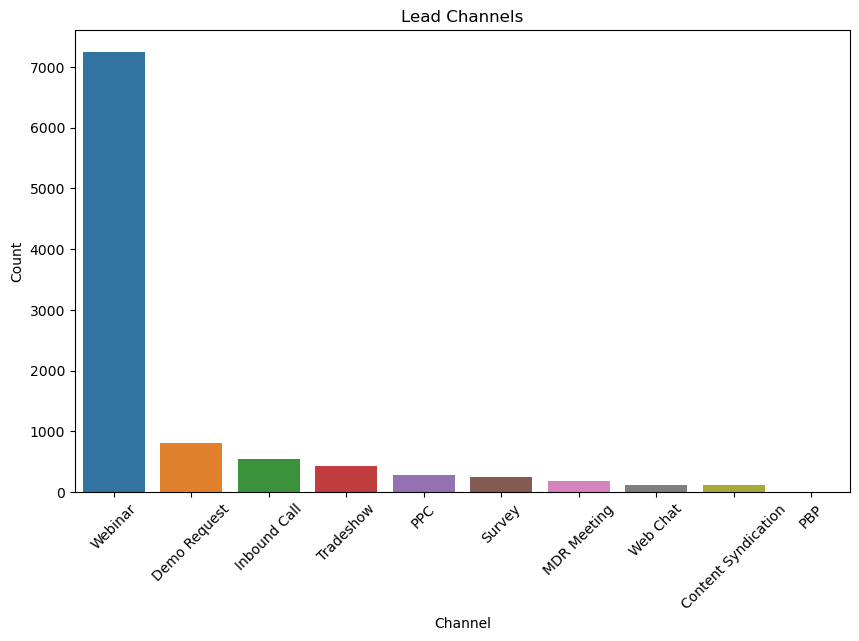

In [621]:
channel_counts = df['channel'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=channel_counts.index, y=channel_counts.values)
plt.title('Lead Channels')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()

#### Bivariate and Multi-variate Analysis
As the focus of this analysis and ML building is geared toward where to prioritize resources for winning leads, bivariate analyses will focus on the target variable.  Categorical variables will be encoded accordingly for proper analysis.

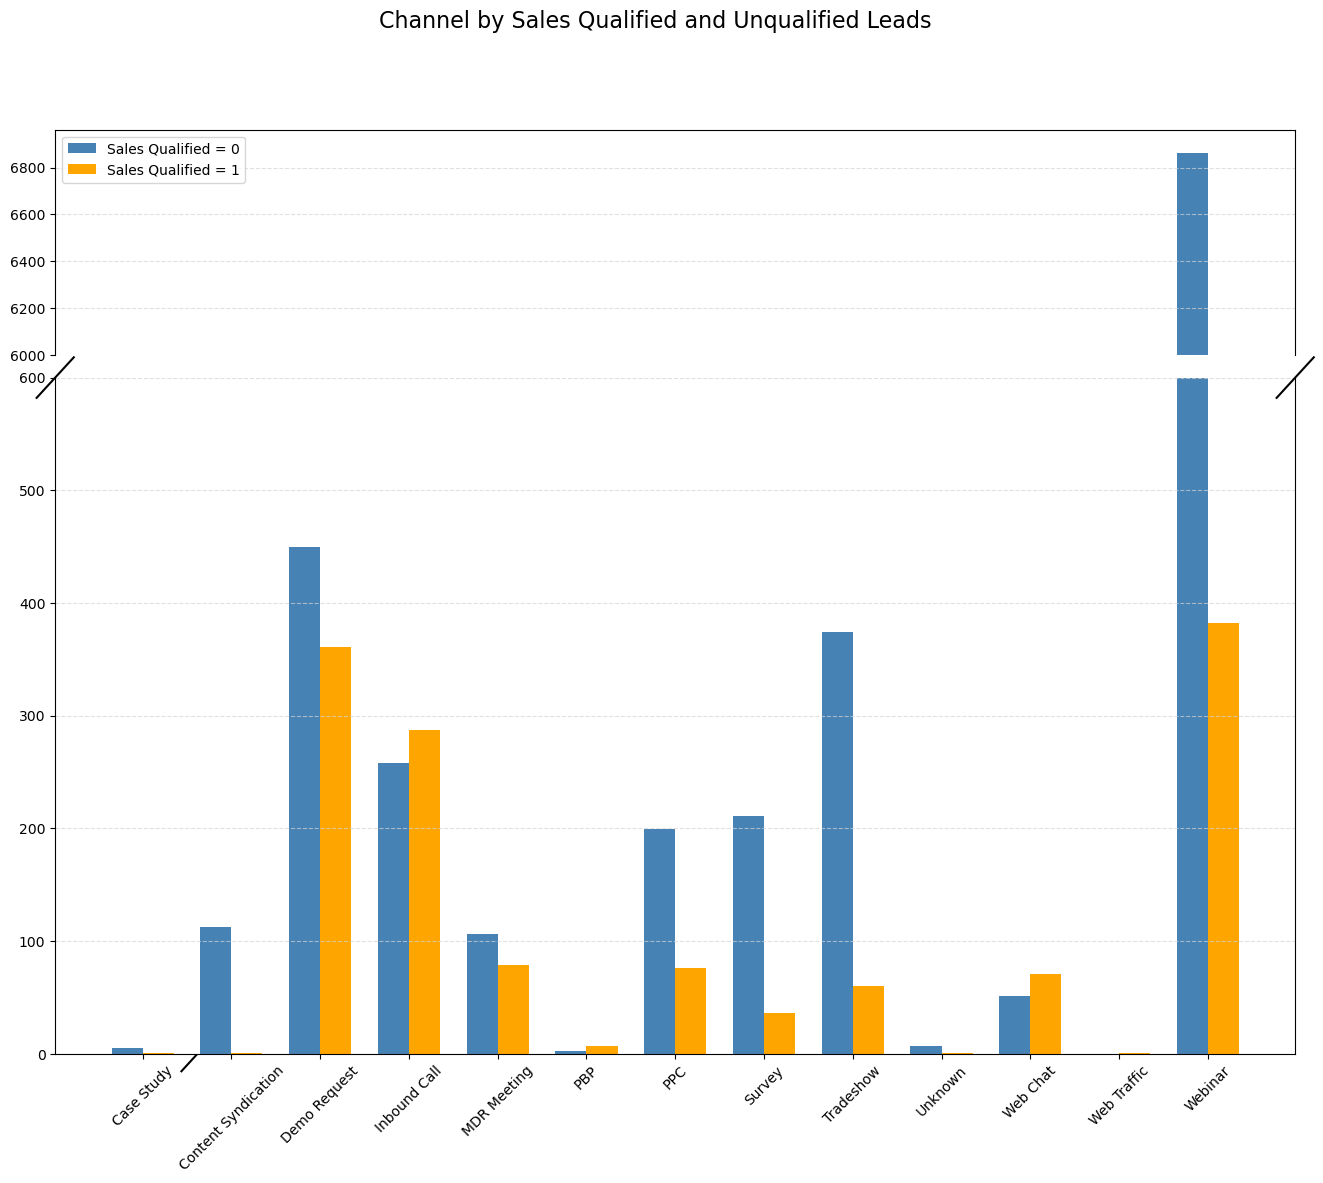

sales_qualified     0    1  Proportion_Qualified
channel                                         
Web Traffic         0    1              1.000000
PBP                 2    7              0.777778
Web Chat           51   71              0.581967
Inbound Call      258  287              0.526606
Demo Request      450  361              0.445129
MDR Meeting       106   79              0.427027
PPC               199   76              0.276364
Case Study          5    1              0.166667
Survey            211   36              0.145749
Tradeshow         374   60              0.138249
Unknown             7    1              0.125000
Webinar          6862  382              0.052733


In [622]:
channel_counts = df.groupby(['channel', 'sales_qualified'], observed=False).size().unstack(fill_value=0)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 12), gridspec_kw={'height_ratios': [1, 3]})
width = 0.35  
x = np.arange(len(channel_counts))  
ax1.bar(x - width/2, channel_counts[0], width, label='Sales Qualified = 0', color='steelblue')
ax1.bar(x + width/2, channel_counts[1], width, label='Sales Qualified = 1', color='orange')
ax1.set_ylim(6000, channel_counts.max().max() + 100)  # Adjust upper limit as needed
ax2.bar(x - width/2, channel_counts[0], width, label='Sales Qualified = 0', color='steelblue')
ax2.bar(x + width/2, channel_counts[1], width, label='Sales Qualified = 1', color='orange')
ax2.set_ylim(0, 600)  # Lower limit of the second subplot
ax1.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7, zorder=0)
ax2.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7, zorder=0) 
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False, top=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax1.plot((-d, +d), (-d * 2, +d * 2), **kwargs)       
ax1.plot((1 - d, 1 + d), (-d * 2, +d * 2), **kwargs)  
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d * 2, 1 + d * 2), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - d * 2, 1 + d * 2), **kwargs) 
ax2.set_xticks(x)
ax2.set_xticklabels(channel_counts.index, rotation=45)  
ax1.legend()
plt.suptitle('Channel by Sales Qualified and Unqualified Leads', fontsize=16)
plt.subplots_adjust(hspace=0.05) 
plt.show()
channel_qualified_counts = df.groupby(['channel', 'sales_qualified']).size().unstack(fill_value=0)
channel_qualified_counts['Proportion_Qualified'] = channel_qualified_counts[1] / (channel_qualified_counts[0] + channel_qualified_counts[1])
sorted_by_proportion = channel_qualified_counts.sort_values(by='Proportion_Qualified', ascending=False)
top_proportions = sorted_by_proportion.head(12)
print(top_proportions)

The most qualified leads come from Webinars and Demo Requests and Inbound calls.  The only channels with more qualified leads than unqualified leads are inbound calls, PBP and web chats.

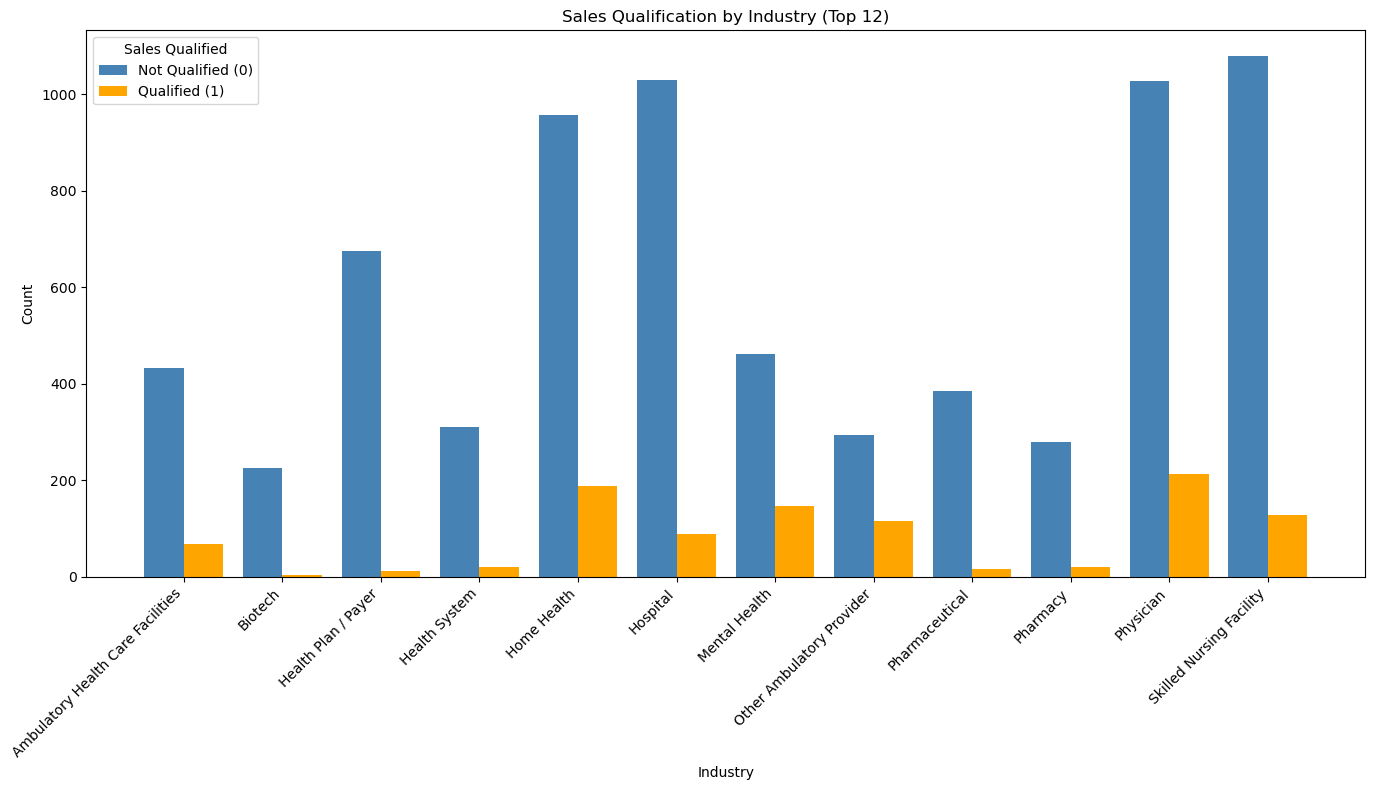

sales_qualified                       0    1  Proportion_Qualified
industry                                                          
Other Ambulatory Provider           294  116              0.282927
Mental Health                       463  147              0.240984
Physician                          1028  214              0.172303
Home Health                         957  189              0.164921
Ambulatory Health Care Facilities   433   68              0.135729
Skilled Nursing Facility           1079  129              0.106788
Hospital                           1029   88              0.078782
Pharmacy                            280   21              0.069767
Health System                       310   20              0.060606
Pharmaceutical                      385   17              0.042289
Health Plan / Payer                 675   13              0.018895
Biotech                             225    4              0.017467


In [623]:
top_industries = df['industry'].value_counts().nlargest(12).index
filtered_df = df[df['industry'].isin(top_industries)]
industry_qualified_counts = filtered_df.groupby(['industry', 'sales_qualified'], observed=False).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.4
indices = range(len(industry_qualified_counts))
ax.bar([i - bar_width / 2 for i in indices], industry_qualified_counts[0], width=bar_width, label='Not Qualified (0)', color='steelblue')
ax.bar([i + bar_width / 2 for i in indices], industry_qualified_counts[1], width=bar_width, label='Qualified (1)', color='orange')
ax.set_xlabel('Industry')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Industry (Top 12)')
ax.set_xticks(indices)
ax.set_xticklabels(industry_qualified_counts.index, rotation=45, ha='right')
ax.legend(title='Sales Qualified')

plt.tight_layout()
plt.show()
industry_qualified_counts['Proportion_Qualified'] = industry_qualified_counts[1] / (industry_qualified_counts[0] + industry_qualified_counts[1])
sorted_by_proportion = industry_qualified_counts.sort_values(by='Proportion_Qualified', ascending=False)
top_proportions = sorted_by_proportion.head(12)
print(top_proportions)

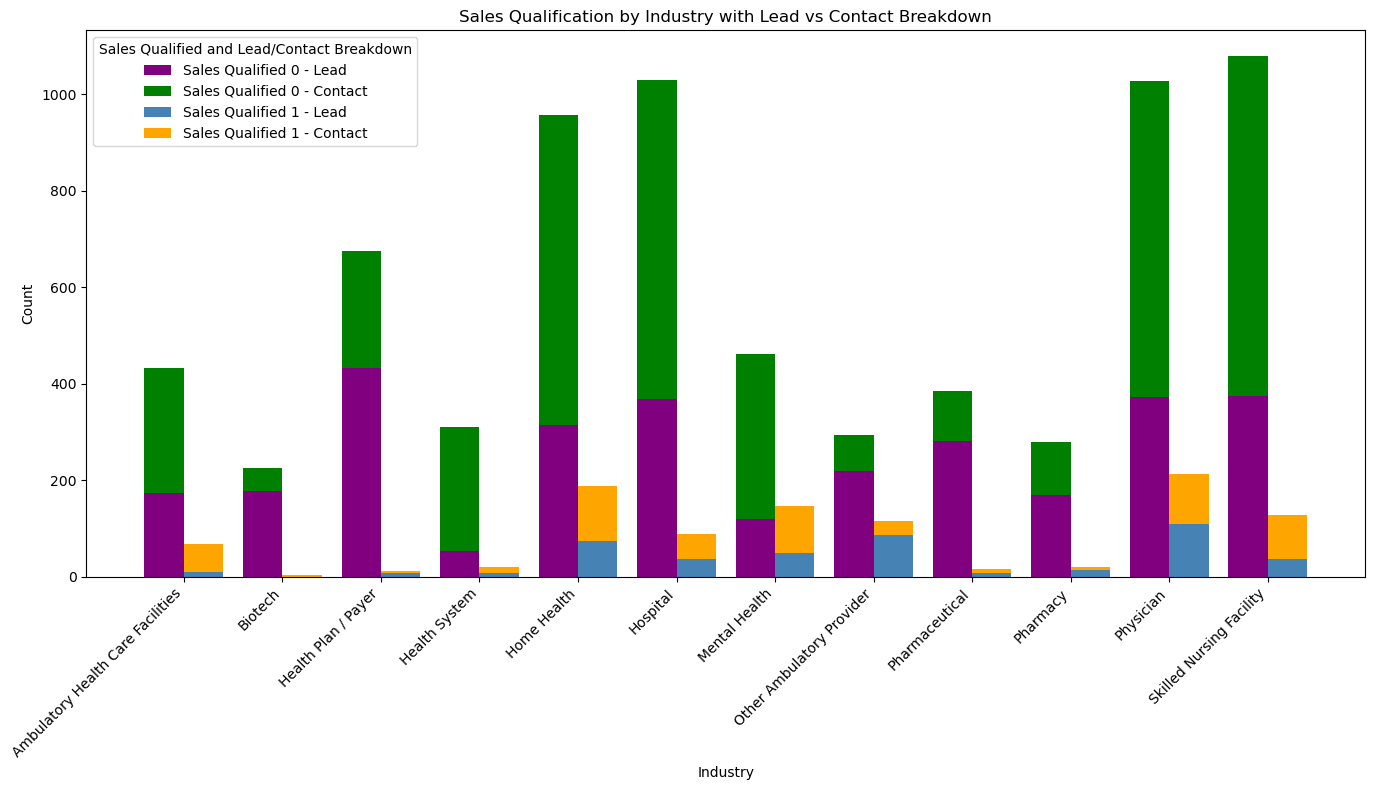

lead_contact                       Leads  Contacts  Proportion of Contacts
industry                                                                  
Biotech                                0         4                1.000000
Ambulatory Health Care Facilities     11        57                0.838235
Skilled Nursing Facility              37        92                0.713178
Mental Health                         49        98                0.666667
Health System                          7        13                0.650000
Home Health                           75       114                0.603175
Hospital                              36        52                0.590909
Pharmaceutical                         7        10                0.588235
Physician                            109       105                0.490654
Health Plan / Payer                    8         5                0.384615
Pharmacy                              14         7                0.333333
Other Ambulatory Provider

C:\Users\orand\AppData\Local\Temp\ipykernel_278964\2128726495.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_qualified_1_data['Proportion_Contact'] = (


In [624]:
top_12_industries = df['industry'].value_counts().head(12).index
industry_qualified_contact_counts = df[df['industry'].isin(top_12_industries)].groupby(['industry', 'sales_qualified', 'lead_contact']).size().unstack(fill_value=0).reset_index()
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.4
indices = np.arange(len(industry_qualified_contact_counts['industry'].unique()))
for i, sq in enumerate([0, 1]):
    subset = industry_qualified_contact_counts[industry_qualified_contact_counts['sales_qualified'] == sq]
    lead_counts = subset['Lead']
    contact_counts = subset['Contact']
    
    if sq == 0:
        lead_color = 'purple'
        contact_color = 'green'
    else:
        lead_color = 'steelblue'
        contact_color = 'orange'
    
    ax.bar(indices + i * bar_width, lead_counts, width=bar_width, label=f'Sales Qualified {sq} - Lead', color=lead_color)
    ax.bar(indices + i * bar_width, contact_counts, width=bar_width, bottom=lead_counts, label=f'Sales Qualified {sq} - Contact', color=contact_color)
ax.set_xlabel('Industry')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Industry with Lead vs Contact Breakdown')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(industry_qualified_contact_counts['industry'].unique(), rotation=45, ha='right')
ax.legend(title='Sales Qualified and Lead/Contact Breakdown')
plt.tight_layout()
plt.show()

sales_qualified_1_data = industry_qualified_contact_counts[industry_qualified_contact_counts['sales_qualified'] == 1]

sales_qualified_1_data['Proportion_Contact'] = (
    sales_qualified_1_data['Contact'] / (sales_qualified_1_data['Lead'] + sales_qualified_1_data['Contact'])
)

formatted_data = sales_qualified_1_data[['industry', 'Lead', 'Contact', 'Proportion_Contact']].copy()
formatted_data.rename(
    columns={
        'Lead': 'Leads',
        'Contact': 'Contacts',
        'Proportion_Contact': 'Proportion of Contacts'
    },
    inplace=True
)
formatted_data = formatted_data.sort_values(by='Proportion of Contacts', ascending=False)

formatted_data.set_index('industry', inplace=True)

print(formatted_data)

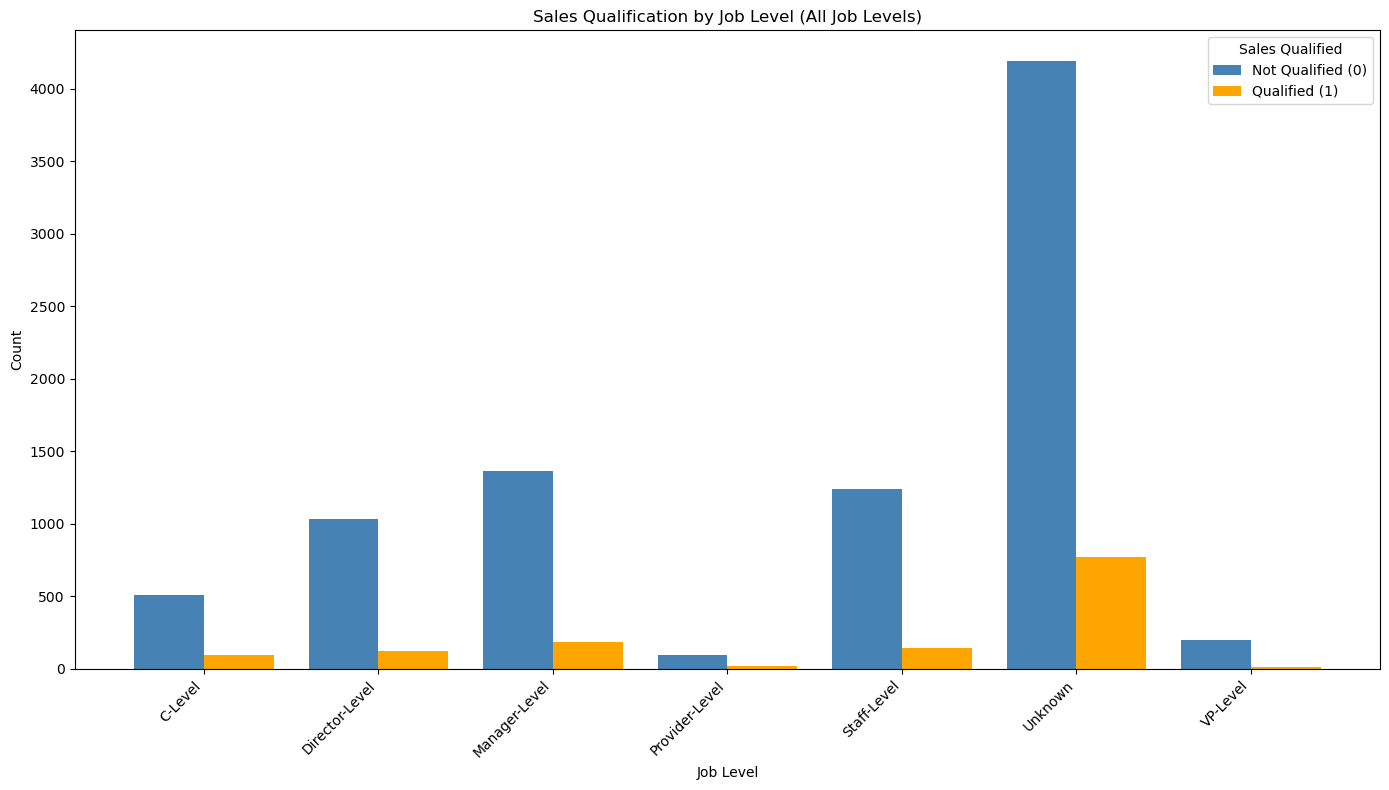

sales_qualified     0    1  Proportion_Qualified
job_level                                       
Provider-Level     93   20              0.176991
C-Level           508   98              0.161716
Unknown          4194  773              0.155627
Manager-Level    1365  188              0.121056
Director-Level   1036  125              0.107666
Staff-Level      1243  146              0.105112
VP-Level          198   13              0.061611


In [625]:
job_level_qualified_counts = df.groupby(['job_level', 'sales_qualified'], observed=False).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.4
indices = range(len(job_level_qualified_counts))
ax.bar([i - bar_width / 2 for i in indices], job_level_qualified_counts[0], width=bar_width, label='Not Qualified (0)', color='steelblue')
ax.bar([i + bar_width / 2 for i in indices], job_level_qualified_counts[1], width=bar_width, label='Qualified (1)', color='orange')
ax.set_xlabel('Job Level')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Job Level (All Job Levels)')
ax.set_xticks(indices)
ax.set_xticklabels(job_level_qualified_counts.index, rotation=45, ha='right')
ax.legend(title='Sales Qualified')
plt.tight_layout()
plt.show()
job_level_qualified_counts = df.groupby(['job_level', 'sales_qualified']).size().unstack(fill_value=0)
job_level_qualified_counts['Proportion_Qualified'] = job_level_qualified_counts[1] / (job_level_qualified_counts[0] + job_level_qualified_counts[1])
sorted_by_proportion = job_level_qualified_counts.sort_values(by='Proportion_Qualified', ascending=False)
top_proportions = sorted_by_proportion
print(top_proportions)

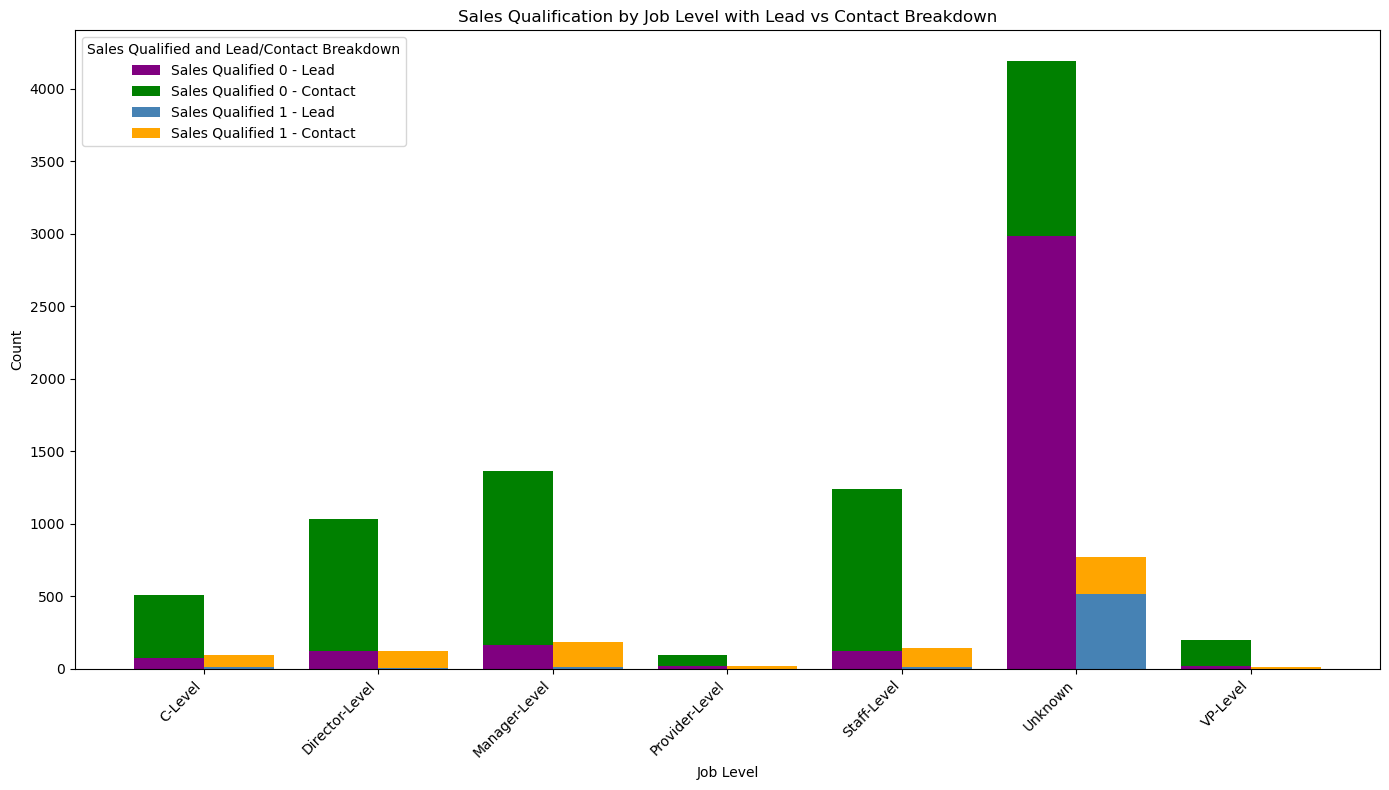

lead_contact    Leads  Contacts  Proportion of Contacts
job_level                                              
Provider-Level      1        19                0.950000
Manager-Level      10       178                0.946809
Director-Level      8       117                0.936000
Staff-Level        11       135                0.924658
VP-Level            1        12                0.923077
C-Level            13        85                0.867347
Unknown           518       255                0.329884


C:\Users\orand\AppData\Local\Temp\ipykernel_278964\3989575164.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_qualified_1_data['Proportion_Contact'] = (


In [626]:
job_levels = df['job_level'].value_counts().head(12).index
job_level_qualified_contact_counts = df[df['job_level'].isin(job_levels)].groupby(['job_level', 'sales_qualified', 'lead_contact']).size().unstack(fill_value=0).reset_index()

fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.4
indices = np.arange(len(job_level_qualified_contact_counts['job_level'].unique()))
for i, sq in enumerate([0, 1]):
    subset = job_level_qualified_contact_counts[job_level_qualified_contact_counts['sales_qualified'] == sq]
    lead_counts = subset['Lead']
    contact_counts = subset['Contact']
    
    if sq == 0:
        lead_color = 'purple'
        contact_color = 'green'
    else:
        lead_color = 'steelblue'
        contact_color = 'orange'
    
    ax.bar(indices + i * bar_width, lead_counts, width=bar_width, label=f'Sales Qualified {sq} - Lead', color=lead_color)
    ax.bar(indices + i * bar_width, contact_counts, width=bar_width, bottom=lead_counts, label=f'Sales Qualified {sq} - Contact', color=contact_color)
ax.set_xlabel('Job Level')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Job Level with Lead vs Contact Breakdown')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(job_level_qualified_contact_counts['job_level'].unique(), rotation=45, ha='right')
ax.legend(title='Sales Qualified and Lead/Contact Breakdown')
plt.tight_layout()
plt.show()
sales_qualified_1_data = job_level_qualified_contact_counts[job_level_qualified_contact_counts['sales_qualified'] == 1]
sales_qualified_1_data['Proportion_Contact'] = (
    sales_qualified_1_data['Contact'] / (sales_qualified_1_data['Lead'] + sales_qualified_1_data['Contact'])
)
formatted_data = sales_qualified_1_data[['job_level', 'Lead', 'Contact', 'Proportion_Contact']].copy()
formatted_data.rename(
    columns={
        'Lead': 'Leads',
        'Contact': 'Contacts',
        'Proportion_Contact': 'Proportion of Contacts'
    },
    inplace=True
)
formatted_data = formatted_data.sort_values(by='Proportion of Contacts', ascending=False)
formatted_data.set_index('job_level', inplace=True)
print(formatted_data)

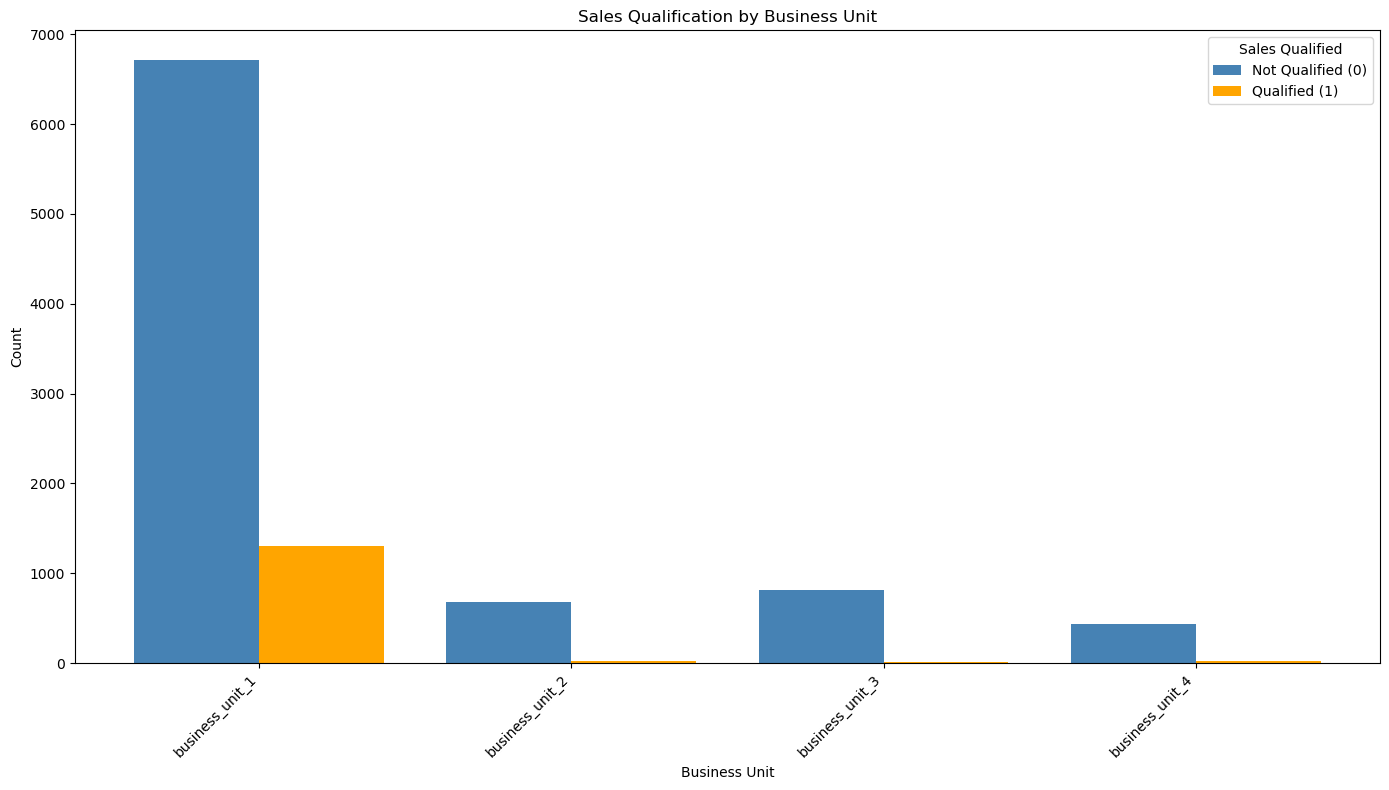

sales_qualified     0     1  Proportion_Qualified
business_unit                                    
business_unit_1  6708  1298              0.162128
business_unit_4   436    23              0.050109
business_unit_2   676    27              0.038407
business_unit_3   817    15              0.018029


In [627]:
business_unit_qualified_counts = df.groupby(['business_unit', 'sales_qualified'],observed=False).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.4
indices = range(len(business_unit_qualified_counts))

ax.bar([i - bar_width / 2 for i in indices], business_unit_qualified_counts[0], width=bar_width, label='Not Qualified (0)', color='steelblue')
ax.bar([i + bar_width / 2 for i in indices], business_unit_qualified_counts[1], width=bar_width, label='Qualified (1)', color='orange')
ax.set_xlabel('Business Unit')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Business Unit')
ax.set_xticks(indices)
ax.set_xticklabels(business_unit_qualified_counts.index, rotation=45, ha='right')
ax.legend(title='Sales Qualified')
plt.tight_layout()
plt.show()
business_unit_qualified_counts = df.groupby(['business_unit', 'sales_qualified']).size().unstack(fill_value=0)
business_unit_qualified_counts['Proportion_Qualified'] = business_unit_qualified_counts[1] / (business_unit_qualified_counts[0] + business_unit_qualified_counts[1])
sorted_by_proportion = business_unit_qualified_counts.sort_values(by='Proportion_Qualified', ascending=False)
print(sorted_by_proportion)

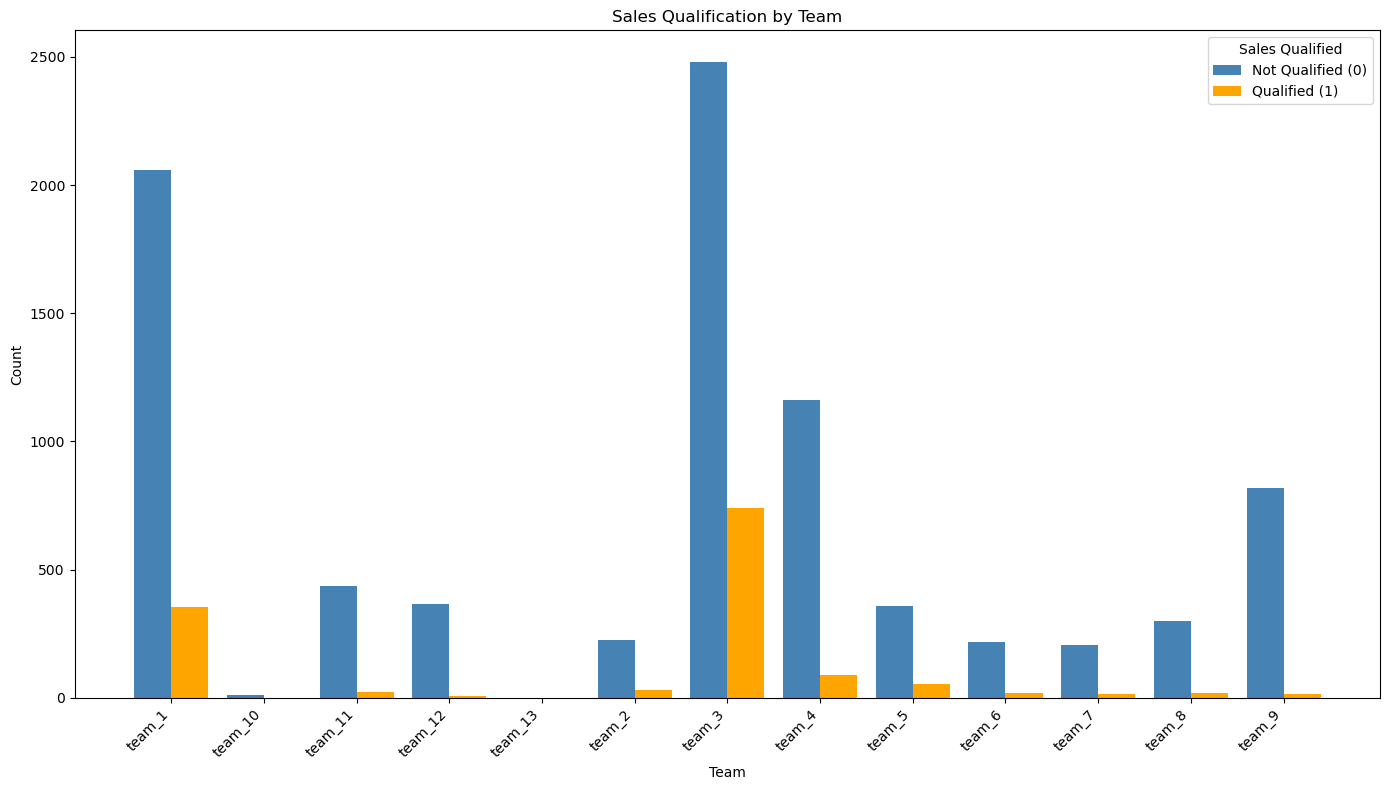

sales_qualified     0    1  Proportion_Qualified
team                                            
team_3           2480  741              0.230053
team_1           2061  356              0.147290
team_5            358   52              0.126829
team_2            225   30              0.117647
team_10            11    1              0.083333
team_6            218   18              0.076271
team_4           1162   88              0.070400
team_7            204   13              0.059908
team_8            299   19              0.059748
team_11           436   23              0.050109
team_12           365    7              0.018817
team_9            817   15              0.018029
team_13             1    0              0.000000


In [628]:
team_qualified_contact_counts = df.groupby(['team', 'sales_qualified']).size().unstack(fill_value=0).reset_index()

fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.4
indices = np.arange(len(team_qualified_contact_counts['team']))
ax.bar(indices, team_qualified_contact_counts[0], width=bar_width, label='Not Qualified (0)', color='steelblue')
ax.bar(indices + bar_width, team_qualified_contact_counts[1], width=bar_width, label='Qualified (1)', color='orange')
ax.set_xlabel('Team')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Team')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(team_qualified_contact_counts['team'], rotation=45, ha='right')
ax.legend(title='Sales Qualified')

plt.tight_layout()
plt.show()
team_qualified_counts = df.groupby(['team', 'sales_qualified']).size().unstack(fill_value=0)
team_qualified_counts['Proportion_Qualified'] = team_qualified_counts[1] / (team_qualified_counts[0] + team_qualified_counts[1])
sorted_by_proportion = team_qualified_counts.sort_values(by='Proportion_Qualified', ascending=False)
print(sorted_by_proportion)

#### Multivariate Analyses


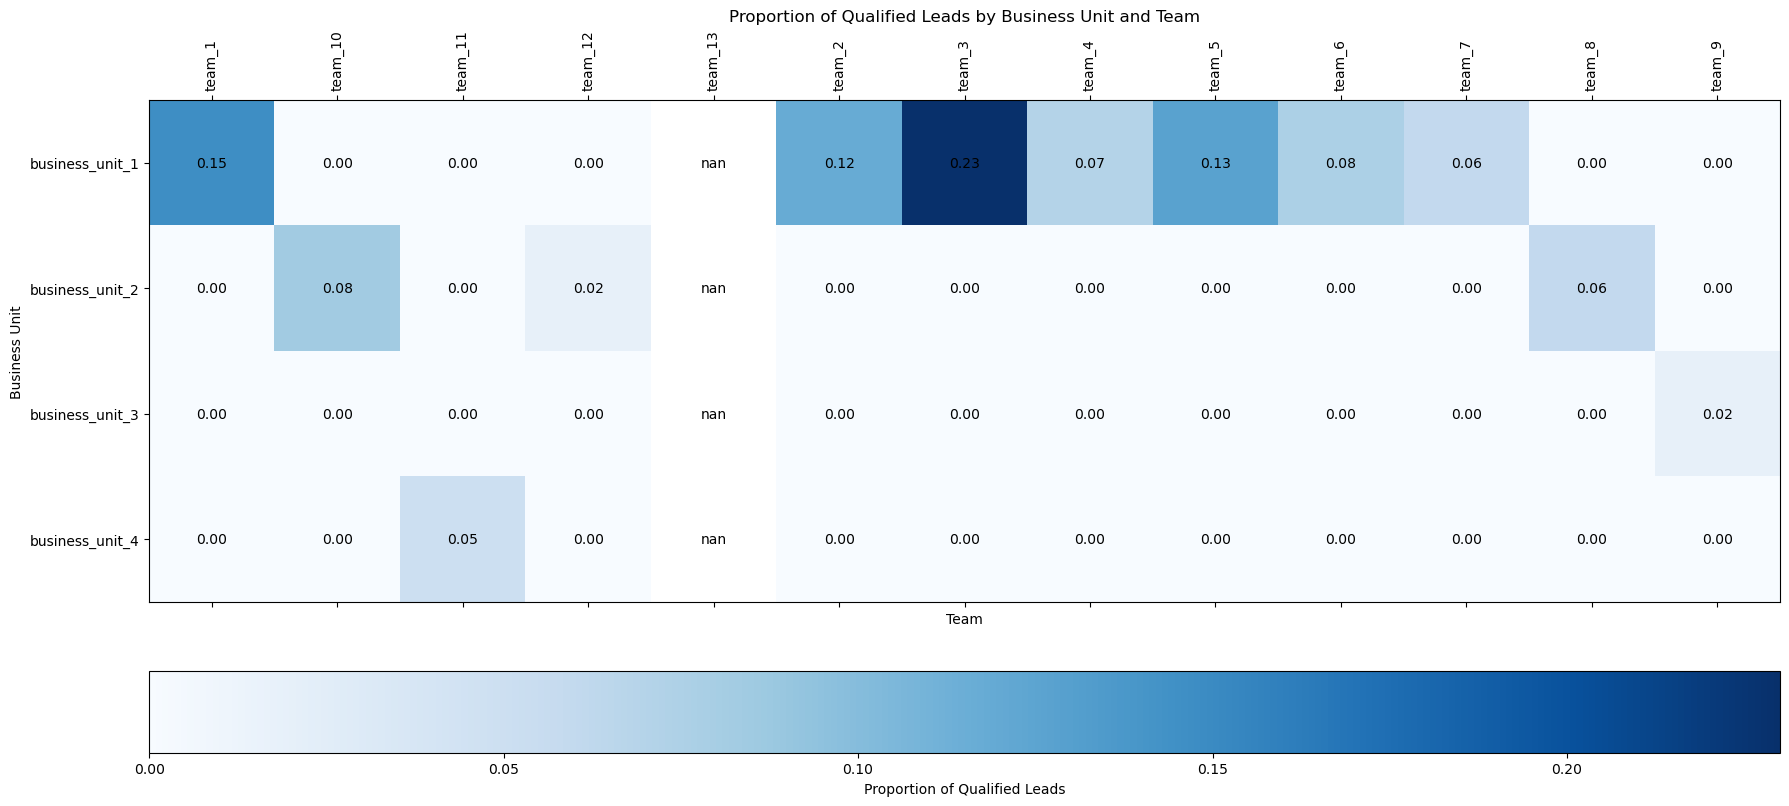

In [629]:
qualified_counts = df[df['sales_qualified'] == 1].groupby(['business_unit', 'team']).size().unstack(fill_value=0)
total_counts = df.groupby(['business_unit', 'team']).size().unstack(fill_value=0)
proportion_qualified = qualified_counts / (total_counts + 1e-10)  # Adding a small value to avoid division by zero
fig, ax = plt.subplots(figsize=(18, 8))
cax = ax.matshow(proportion_qualified, cmap='Blues')
fig.colorbar(cax, ax=ax, orientation='horizontal', pad=0.1, label='Proportion of Qualified Leads')

ax.set_xticks(range(len(proportion_qualified.columns)))
ax.set_yticks(range(len(proportion_qualified.index)))
ax.set_xticklabels(proportion_qualified.columns, rotation=90)
ax.set_yticklabels(proportion_qualified.index)
plt.xlabel('Team')
plt.ylabel('Business Unit')
plt.title('Proportion of Qualified Leads by Business Unit and Team')

for (i, j), val in np.ndenumerate(proportion_qualified.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

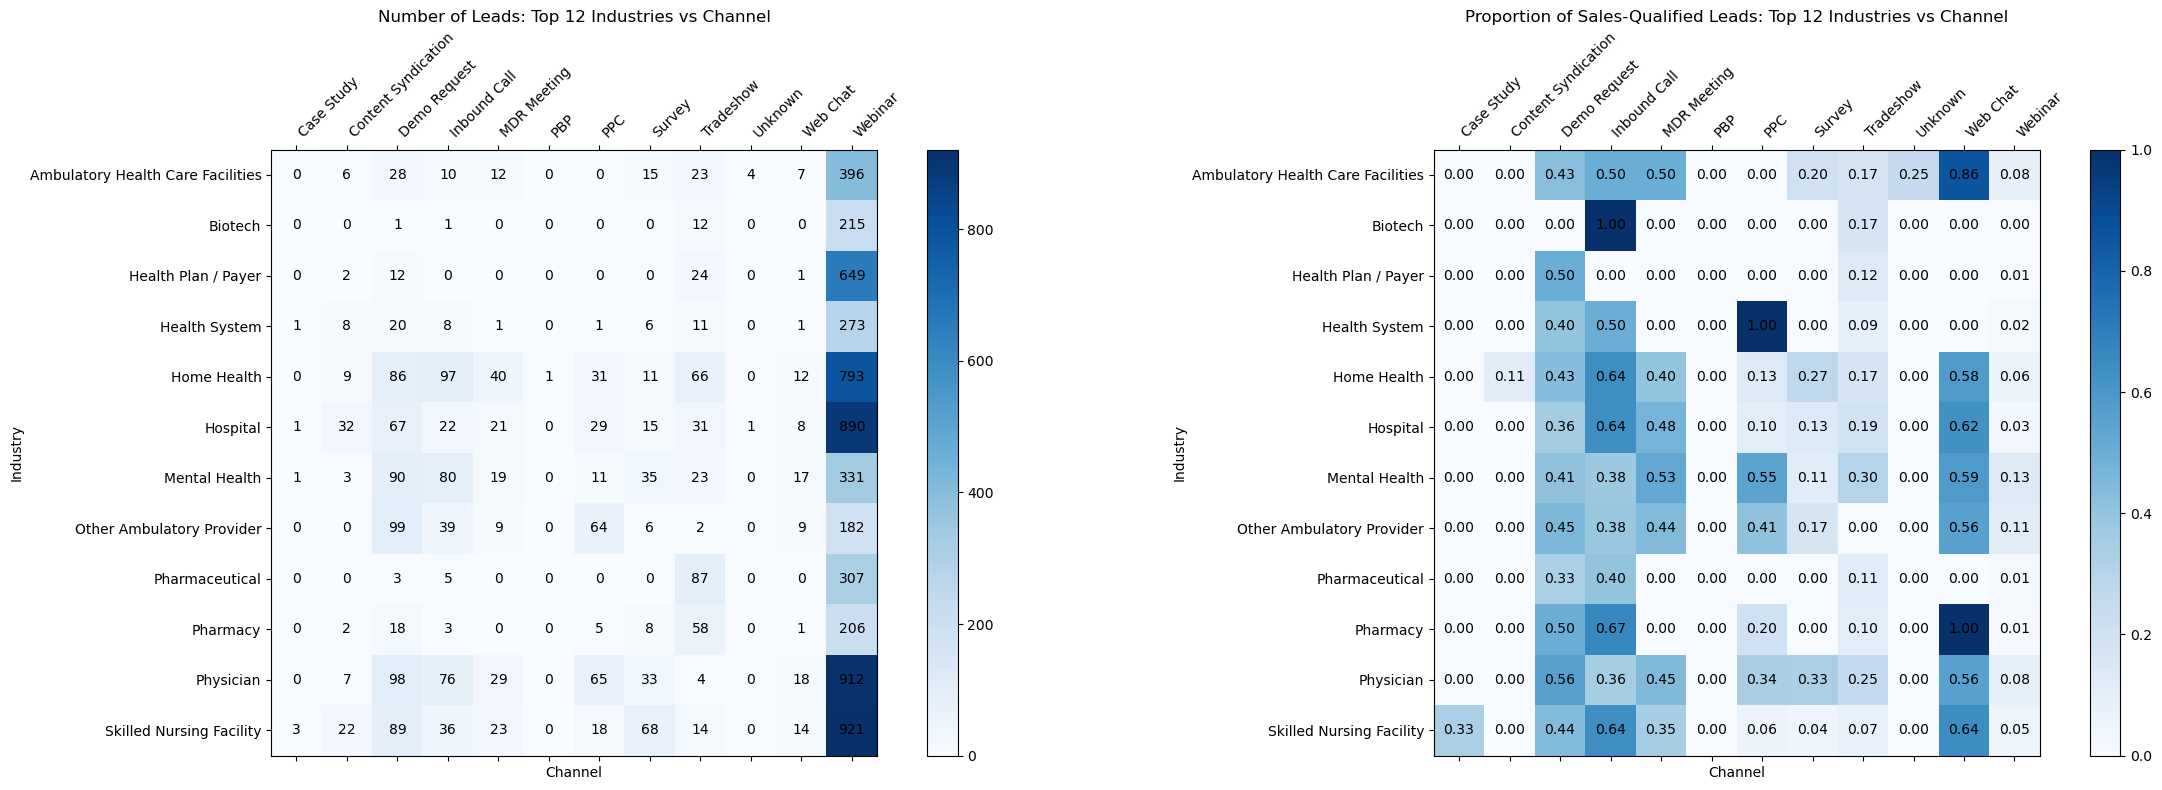

In [630]:
top_12_industries = df['industry'].value_counts().head(12).index
filtered_df = df[df['industry'].isin(top_12_industries) & (df['channel'] != 'web traffic')]
crosstab_count = pd.crosstab(filtered_df['industry'], filtered_df['channel'])
crosstab_proportion = pd.crosstab(filtered_df['industry'], filtered_df['channel'], values=filtered_df['sales_qualified'], aggfunc='mean').fillna(0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

cax1 = ax1.matshow(crosstab_count, cmap='Blues')
fig.colorbar(cax1, ax=ax1)
ax1.set_xticks(range(len(crosstab_count.columns)))
ax1.set_yticks(range(len(crosstab_count.index)))
ax1.set_xticklabels(crosstab_count.columns, rotation=45, ha='left')
ax1.set_yticklabels(crosstab_count.index)
ax1.set_xlabel('Channel')
ax1.set_ylabel('Industry')
ax1.set_title('Number of Leads: Top 12 Industries vs Channel')

for (i, j), val in np.ndenumerate(crosstab_count.values):
    ax1.text(j, i, f'{val}', ha='center', va='center', color='black')

cax2 = ax2.matshow(crosstab_proportion, cmap='Blues')
fig.colorbar(cax2, ax=ax2)
ax2.set_xticks(range(len(crosstab_proportion.columns)))
ax2.set_yticks(range(len(crosstab_proportion.index)))
ax2.set_xticklabels(crosstab_proportion.columns, rotation=45, ha='left')
ax2.set_yticklabels(crosstab_proportion.index)
ax2.set_xlabel('Channel')
ax2.set_ylabel('Industry')
ax2.set_title('Proportion of Sales-Qualified Leads: Top 12 Industries vs Channel')

for (i, j), val in np.ndenumerate(crosstab_proportion.values):
    ax2.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

### One Hot Encoding

In [654]:
categorical_columns = ['business_unit', 'lead_contact', 'job_level', 'industry', 'team', 'channel', 'lead_product']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

df_model = pd.concat([encoded_df, df['sales_qualified']], axis=1)

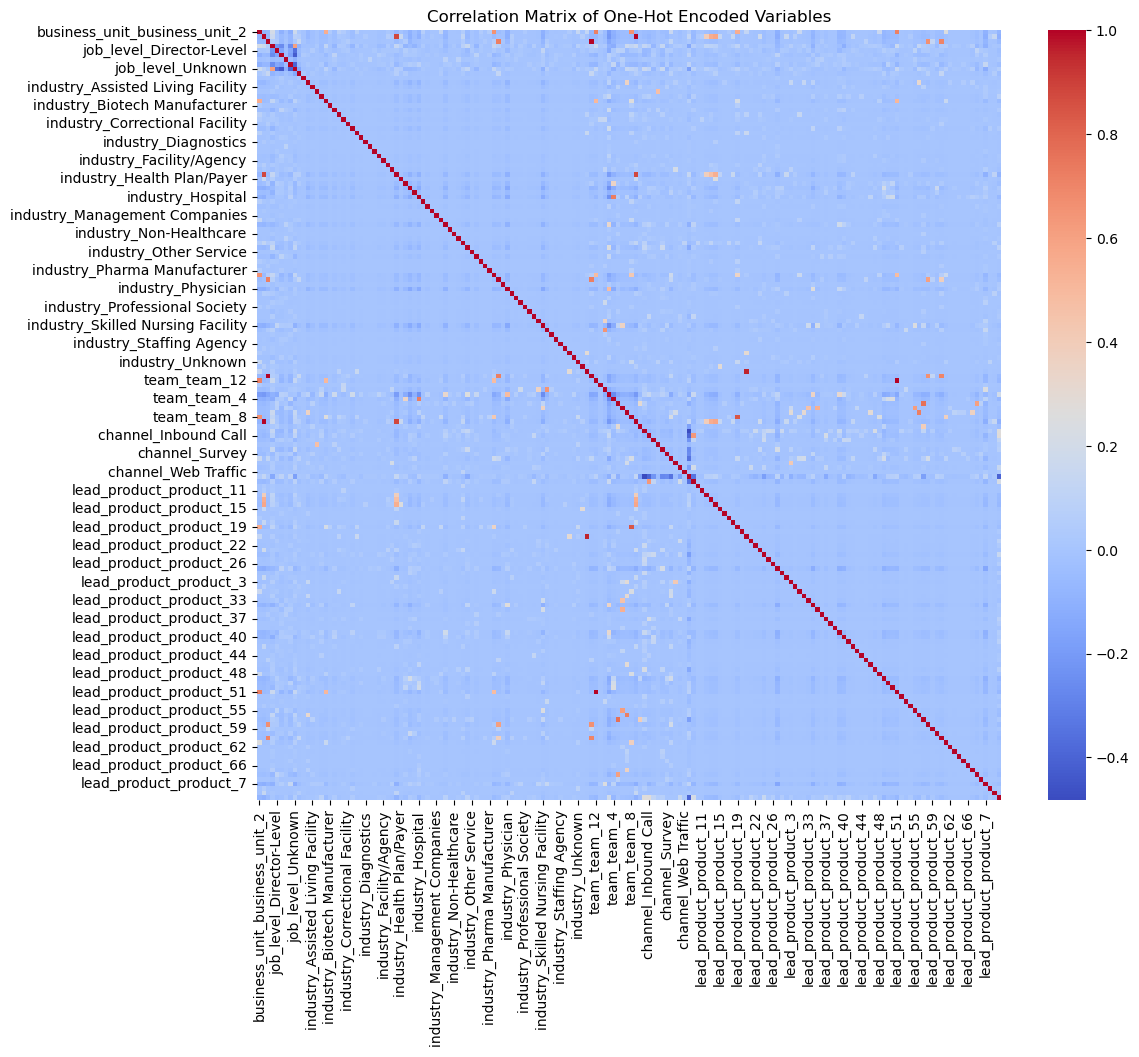

In [655]:
# Correlation Matrix
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of One-Hot Encoded Variables")
plt.show()

In [657]:
# Pairs with high correlation 
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
correlation_flat = correlation_matrix.where(upper_triangle)
high_correlation_pairs = correlation_flat.unstack().dropna().sort_values(ascending=False)
print(high_correlation_pairs[high_correlation_pairs > 0.6])

team_team_9                   business_unit_business_unit_3    1.000000
team_team_11                  business_unit_business_unit_4    1.000000
lead_product_product_51       team_team_12                     0.997205
lead_product_product_20       team_team_10                     0.957379
team_team_9                   industry_Health Plan / Payer     0.880837
industry_Health Plan / Payer  business_unit_business_unit_3    0.880837
lead_product_product_19       team_team_8                      0.840946
lead_product_product_57       team_team_5                      0.767975
team_team_4                   industry_Hospital                0.722219
team_team_11                  industry_Pharmacy                0.722070
industry_Pharmacy             business_unit_business_unit_4    0.722070
lead_product_product_56       team_team_7                      0.721022
team_team_12                  business_unit_business_unit_2    0.714821
lead_product_product_51       business_unit_business_unit_2    0

### Model Building

#### Split Data

In [647]:
X = df_model.drop(columns=['sales_qualified'])
y = df_model['sales_qualified']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Random Forest Model

In [648]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')  
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of being in class 1 (sales_qualified = 1)
y_pred = model.predict(X_test)

#### Evaluate the Model

In [649]:
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_score:.2f}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

AUC-ROC Score: 0.78
Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      1727
           1       0.38      0.52      0.44       273

    accuracy                           0.82      2000
   macro avg       0.65      0.69      0.67      2000
weighted avg       0.85      0.82      0.83      2000



#### Logistic Regression Using Feature Importance

In [650]:
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Top Features:\n", feature_importances.head(10))

Top Features:
                      Feature  Importance
97           channel_Webinar    0.165120
87      channel_Demo Request    0.060639
88      channel_Inbound Call    0.050634
79               team_team_3    0.045882
3          lead_contact_Lead    0.038907
8          job_level_Unknown    0.029953
98    lead_product_product_1    0.026898
5    job_level_Manager-Level    0.026763
7      job_level_Staff-Level    0.024272
4   job_level_Director-Level    0.021491


In [666]:
model = LogisticRegression(max_iter=500, random_state=42)
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Selected Features:\n", selected_features)

Selected Features:
 Index(['business_unit_business_unit_2', 'team_team_7', 'team_team_9',
       'channel_Content Syndication', 'channel_Survey', 'channel_Webinar',
       'lead_product_product_21', 'lead_product_product_49',
       'lead_product_product_53', 'lead_product_product_58'],
      dtype='object')


In [667]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [668]:
model_selected = LogisticRegression(max_iter=500, random_state=42)
model_selected.fit(X_train_selected, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [669]:
y_pred = model_selected.predict(X_test_selected)
y_pred_proba = model_selected.predict_proba(X_test_selected)[:, 1]

In [671]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93      1727
           1       1.00      0.01      0.01       273

    accuracy                           0.86      2000
   macro avg       0.93      0.50      0.47      2000
weighted avg       0.88      0.86      0.80      2000

AUC-ROC: 0.80
Confusion Matrix:
 [[1727    0]
 [ 271    2]]


#### Logistic Regression Model

In [658]:
model = LogisticRegression(solver='lbfgs', max_iter=500, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

#### Evaluate the Model

In [659]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.78
AUC-ROC: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      1727
           1       0.35      0.71      0.47       273

    accuracy                           0.78      2000
   macro avg       0.65      0.75      0.67      2000
weighted avg       0.86      0.78      0.81      2000



In [660]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Display top positive and negative coefficients
print("Top Positive Influences:\n", coefficients.head(10))
print("\nTop Negative Influences:\n", coefficients.tail(10))

Top Positive Influences:
                      Feature  Coefficient
126  lead_product_product_35     1.597144
59     industry_Professional     1.464571
111  lead_product_product_21     1.424117
95          channel_Web Chat     1.405580
88      channel_Inbound Call     1.195354
90               channel_PBP     1.124250
87      channel_Demo Request     1.055788
120   lead_product_product_3     1.004916
165   lead_product_product_8     0.977077
127  lead_product_product_36     0.958449

Top Negative Influences:
                                            Feature  Coefficient
101                        lead_product_product_12    -1.107245
30                            industry_Health Plan    -1.111998
85                                     team_team_9    -1.217498
1                    business_unit_business_unit_3    -1.217498
67   industry_Speech, Language and Hearing Service    -1.248440
149                        lead_product_product_56    -1.368919
146                        lead_produ

#### SMOTE for attempt at better evaluation metrics

In [662]:
print("Class Distribution in Training Data:")
print(y_train.value_counts())

Class Distribution in Training Data:
sales_qualified
0    6910
1    1090
Name: count, dtype: int64


In [663]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class Distribution After SMOTE:")
print(y_train_resampled.value_counts())

Class Distribution After SMOTE:
sales_qualified
0    6910
1    6910
Name: count, dtype: int64


In [664]:
model = LogisticRegression(solver='lbfgs', max_iter=500, random_state=42)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      1727
           1       0.35      0.70      0.47       273

    accuracy                           0.78      2000
   macro avg       0.65      0.75      0.66      2000
weighted avg       0.86      0.78      0.81      2000

Accuracy: 0.78


SMOTE did not improve the model performance